<div style="text-align: center; padding: 20px; background-color: #000000; border-radius: 10px; margin: 20px 0;">
    <h1 style="color: #008080 	;">Data Insights on Spotify using PySpark<h1>
    <hr style="border: 2px solid #008080;">
</div>

### Needed Libraries

In [1]:
from IPython.display import display, HTML
display(HTML('<style>pre { white-space: pre !important; }</style>'))
import pyspark as ps
import pyspark.sql.functions as F
from pyspark.sql.functions import explode, desc, countDistinct, count, avg
from pyspark.sql.functions import desc, countDistinct, count
from pyspark.sql.functions import col, when
from pyspark.sql.functions import arrays_zip
from pyspark.sql.functions import udf
from pyspark.sql.window import Window
from pyspark.sql.types import ArrayType, StringType
import matplotlib.pyplot as plt
from pyspark.sql.functions import floor
from scipy.stats import norm
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
import seaborn as sns
import numpy as np
import calendar

In [2]:
spark = ps.sql.SparkSession.builder \
    .master("local") \
    .appName("spotify") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

In [3]:
def show_df(df, n=5):
    df.show(n)
    print("number of rows: ",df.count())

### Read From parquet file

At first, we need to read the data from the parquet file. We can use the `spark.read.parquet` method to read the data from the parquet file. As we can see there are 1204025 records and 24 columns in the dataset.

In [4]:
spotify_df = spark.read.parquet("spotify.parquet")
show_df(spotify_df)

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------+-----------+--------+------------+------+---+------------------+----+-----------+------------+----------------+--------+-------+-------+-----------+--------------+----+------------+
|                  id|                name|               album|            album_id|             artists|          artist_ids|track_number|disc_number|explicit|danceability|energy|key|          loudness|mode|speechiness|acousticness|instrumentalness|liveness|valence|  tempo|duration_ms|time_signature|year|release_date|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------+-----------+--------+------------+------+---+------------------+----+-----------+------------+----------------+--------+-------+-------+-----------+--------------+----+------------+
|7lmeHLHBe4nmXzuXc...|            

In [5]:
spotify_df.printSchema()

root
 |-- id: string (nullable = true)
 |-- name: string (nullable = true)
 |-- album: string (nullable = true)
 |-- album_id: string (nullable = true)
 |-- artists: string (nullable = true)
 |-- artist_ids: string (nullable = true)
 |-- track_number: long (nullable = true)
 |-- disc_number: long (nullable = true)
 |-- explicit: boolean (nullable = true)
 |-- danceability: double (nullable = true)
 |-- energy: double (nullable = true)
 |-- key: long (nullable = true)
 |-- loudness: double (nullable = true)
 |-- mode: long (nullable = true)
 |-- speechiness: double (nullable = true)
 |-- acousticness: double (nullable = true)
 |-- instrumentalness: double (nullable = true)
 |-- liveness: double (nullable = true)
 |-- valence: double (nullable = true)
 |-- tempo: double (nullable = true)
 |-- duration_ms: long (nullable = true)
 |-- time_signature: double (nullable = true)
 |-- year: long (nullable = true)
 |-- release_date: string (nullable = true)



## **Preprocessing**

### Data Type Conversion

As we can see from the schema of the dataset, there are some columns that are not in the correct data type. `release_date` column is in the string format, we need to convert it to the date format. Also `explicit` column is in the boolean format, we need to convert it to the integer format in order to use it in numberical calculations like correlation.  
Also `artists` and `artist_ids` are columns that contain lists of artist names and ids but they are in the string format. We need to convert them to the array format in order to use them in the analysis.

In [7]:
def string_to_list(string):
    return string[1:-1].replace("'", "").split(", ")

spotify_df = spotify_df.withColumn("release_date", spotify_df["release_date"].cast("date"))
string_to_list_udf = udf(string_to_list, ArrayType(StringType()))
spotify_df = spotify_df.withColumn("artist_ids", string_to_list_udf("artist_ids"))
spotify_df = spotify_df.withColumn("artists", string_to_list_udf("artists"))
spotify_df.printSchema()

root
 |-- id: string (nullable = true)
 |-- name: string (nullable = true)
 |-- album: string (nullable = true)
 |-- album_id: string (nullable = true)
 |-- artists: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- artist_ids: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- track_number: long (nullable = true)
 |-- disc_number: long (nullable = true)
 |-- explicit: boolean (nullable = true)
 |-- danceability: double (nullable = true)
 |-- energy: double (nullable = true)
 |-- key: long (nullable = true)
 |-- loudness: double (nullable = true)
 |-- mode: long (nullable = true)
 |-- speechiness: double (nullable = true)
 |-- acousticness: double (nullable = true)
 |-- instrumentalness: double (nullable = true)
 |-- liveness: double (nullable = true)
 |-- valence: double (nullable = true)
 |-- tempo: double (nullable = true)
 |-- duration_ms: long (nullable = true)
 |-- time_signature: double (nullable = true)
 |-- year: long (nulla

In [8]:
def count_nulls(df):
    null_counts = {col_name: df.where(col(col_name).isNull()).count() for col_name in df.columns}
    for col_name, count in null_counts.items():
        display(HTML(f"<b>{col_name}</b> has <b>{count}</b> null values"))

count_nulls(spotify_df)

As we can see the number of null redcords in `name` and `album` columns are not 0 but they are very low. We can drop these records.

In [10]:
spotify_df = spotify_df.dropna(subset=['name', 'album'])
count_nulls(spotify_df)

## **Data Analysis and Insights**

<!-- first, we create plot for frequency of each music attribute -->
First, we create a plot for each music attribute to see the frequency of each attribute. For further information about what these attributes mean, you can check this [link](https://medium.com/analytics-vidhya/spotify-music-data-analysis-part-3-9097829df16e/).

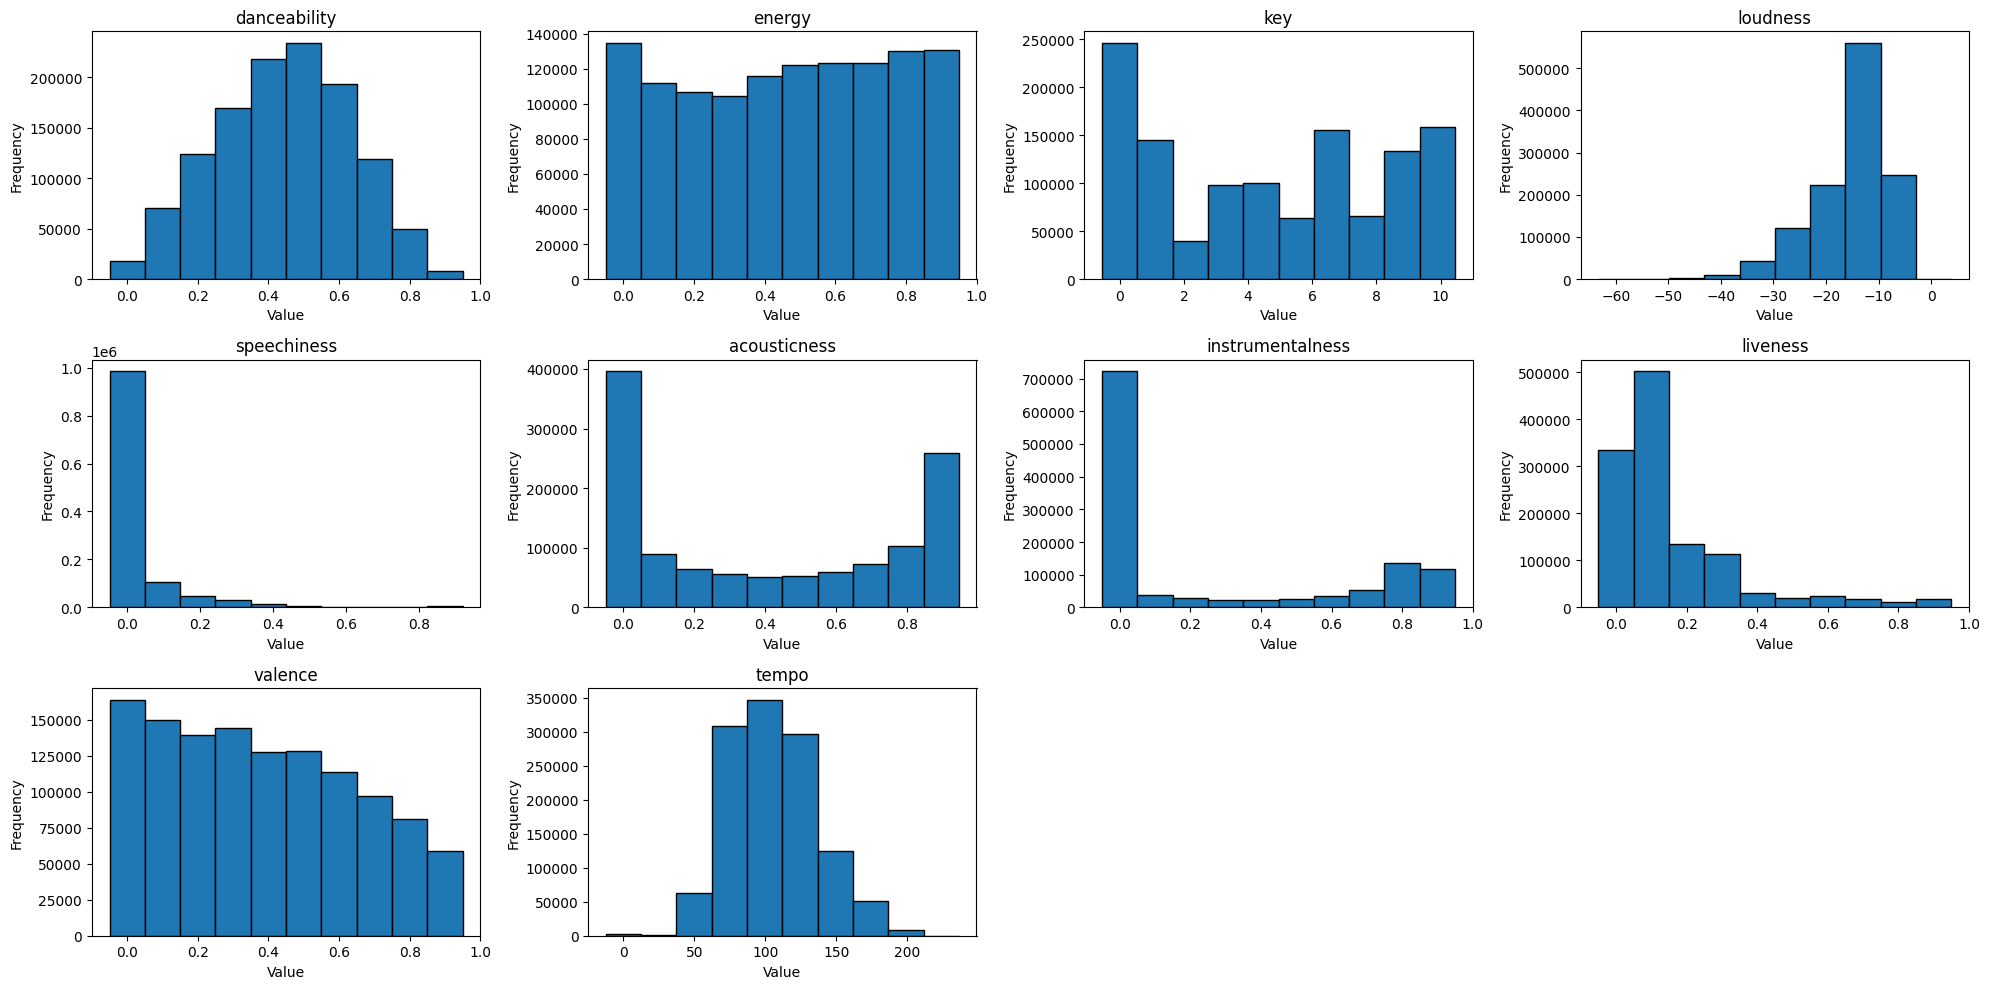

In [11]:
features = ['danceability', 'energy', 'key', 'loudness' ,'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence','tempo']

plt.figure(figsize=(20, 10))
for feature in features:
		frequency = spotify_df.select(feature).rdd.flatMap(lambda x: x).histogram(10)
		frequencies = frequency[1]
		edges = frequency[0]
		plt.subplot(3, 4, features.index(feature) + 1)
		plt.bar(edges[:-1], frequencies, width=np.diff(edges), edgecolor="black")
		plt.title(feature)
		plt.xlabel("Value")
		plt.ylabel("Frequency")
		
plt.tight_layout()
plt.show()

Let's delve deeper into the dataset's columns and explore the distribution of each one.

### Explicit Songs Distribution

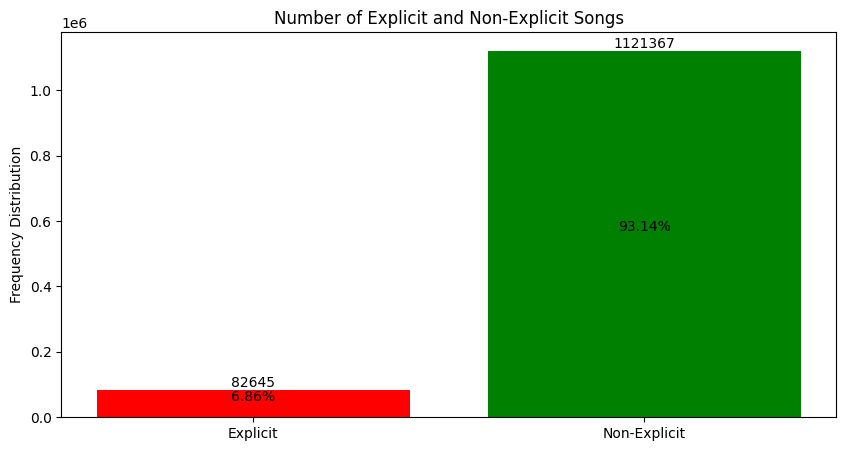

In [236]:
# Explicit distribution
def explicit_song_distribution_plot():
	plt.figure(figsize=(10, 5))
	explicit = spotify_df.groupBy("explicit").count().collect()
	colors = ['red' if row['explicit'] == 1 else 'green' for row in explicit]
	plt.bar([0, 1], [row['count'] for row in explicit], color=colors)
	plt.xticks([0, 1], ['Explicit', 'Non-Explicit'])
	plt.ylabel('Frequency Distribution')
	plt.title('Number of Explicit and Non-Explicit Songs')
	for i in range(2):
			plt.text(i, explicit[i][1], str(explicit[i][1]), ha="center", va="bottom")
			plt.text(i, explicit[i][1] / 2, f"{explicit[i][1] / spotify_df.count() * 100:.2f}%", ha="center", va="bottom")
	plt.show()

explicit_song_distribution_plot()

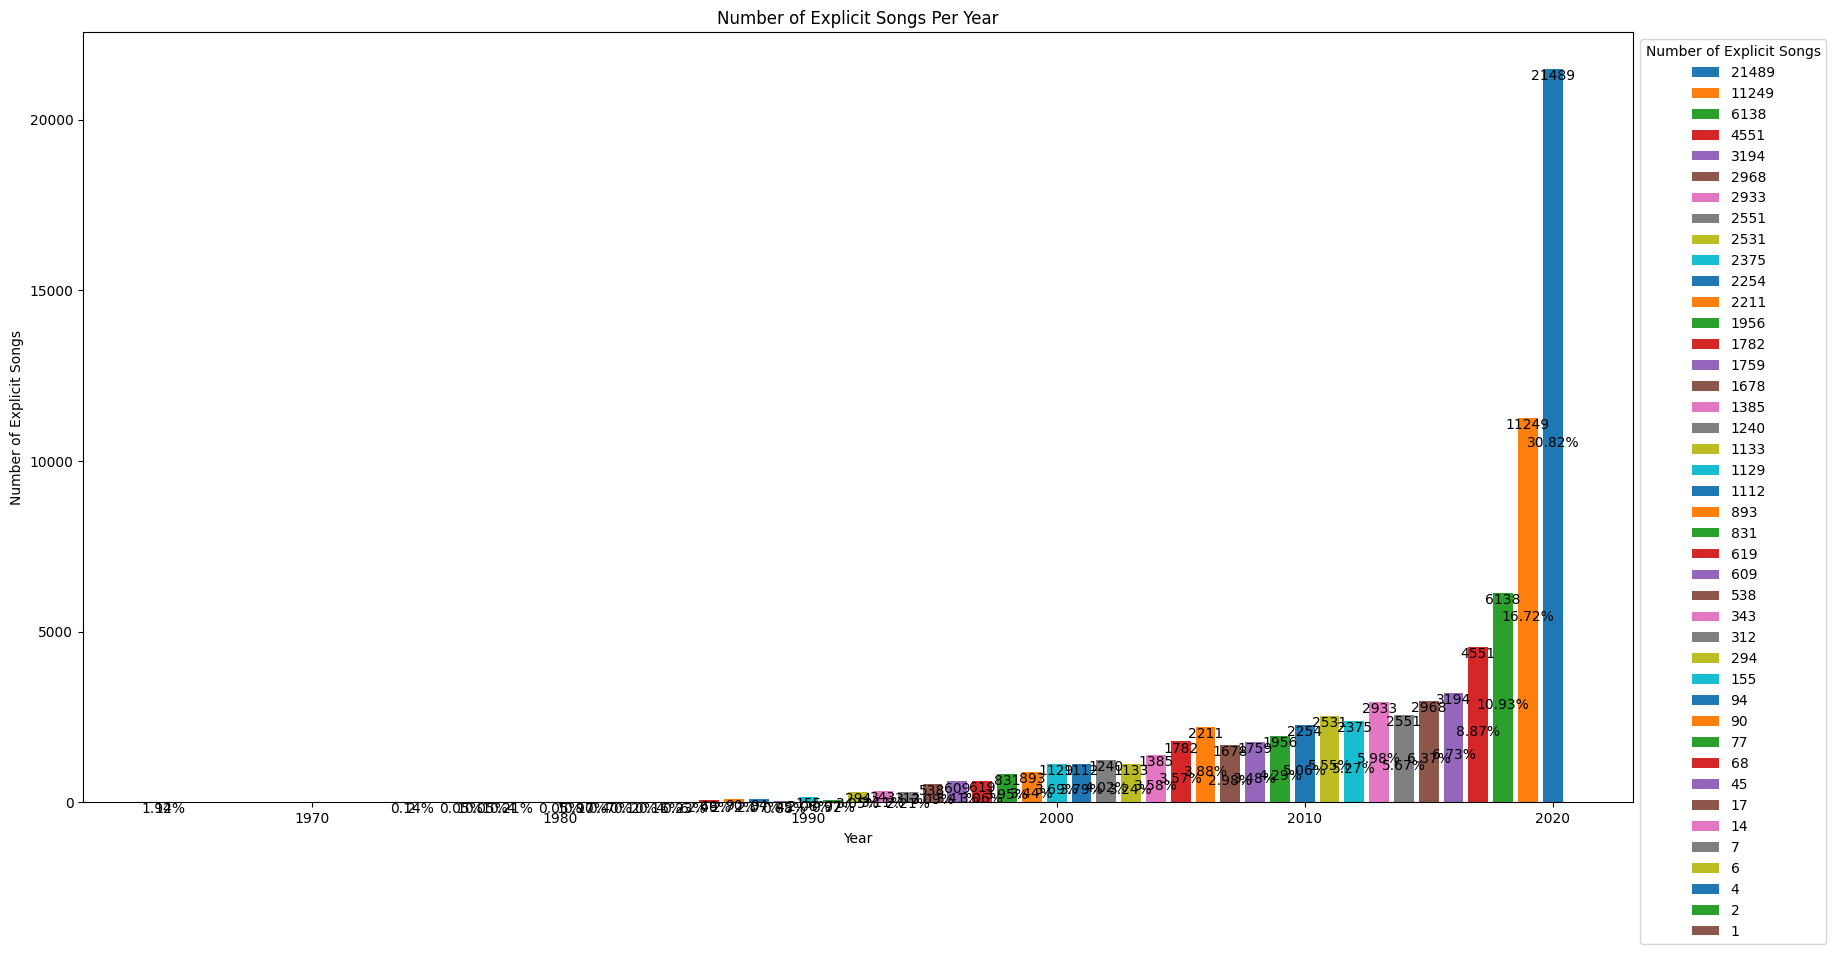

In [24]:
def explicit_song_distribution_per_year_plot():
    explicit_songs_count = spotify_df.groupBy("explicit", "year").count().collect()

    explicit_songs = [row['count'] for row in explicit_songs_count if row['explicit'] == 1]
    years = [row['year'] for row in explicit_songs_count if row['explicit'] == 1]

    sorted_data = sorted(zip(explicit_songs, years), key=lambda x: x[0], reverse=True)
    sorted_explicit_songs, sorted_years = zip(*sorted_data)

    plt.figure(figsize=(20, 10))

    for i in range(len(sorted_years)):
        plt.bar(sorted_years[i], sorted_explicit_songs[i], label=f"{sorted_explicit_songs[i]}")
        plt.text(sorted_years[i], sorted_explicit_songs[i], str(sorted_explicit_songs[i]), ha='center', va='top')
        # percentage of explicit songs / total songs of that year
        plt.text(sorted_years[i], sorted_explicit_songs[i] / 2, f"{sorted_explicit_songs[i] / spotify_df.filter(spotify_df['year'] == sorted_years[i]).count() * 100:.2f}%", ha = 'center', va = 'top')
              

    plt.xlabel("Year")
    plt.ylabel("Number of Explicit Songs")
    plt.title("Number of Explicit Songs Per Year")

    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
   
    sorted_legend = sorted(by_label.items() , key=lambda x: int(x[0]), reverse=True)
    plt.legend([val for key, val in sorted_legend], [key for key, val in sorted_legend], title="Number of Explicit Songs",loc='upper left', bbox_to_anchor=(1,1))
    
  
    plt.show()

explicit_song_distribution_per_year_plot()


### Number of Songs per Year

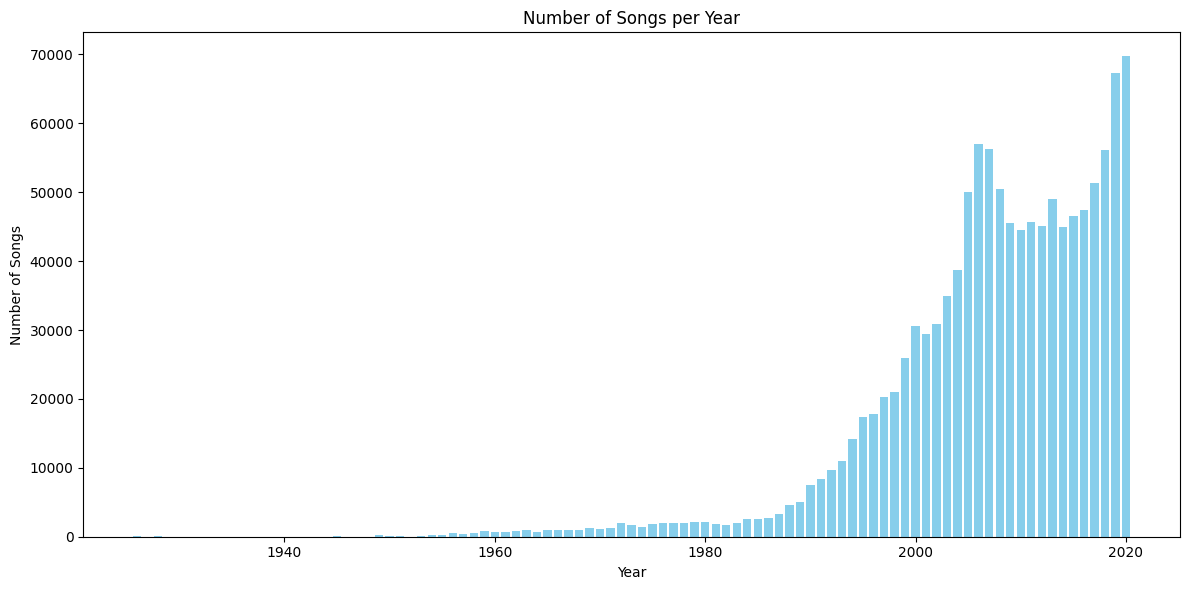

In [25]:
# Number of Songs per Year distribution
year_df = spotify_df.groupBy("year").count()
year_df_filtered = year_df.filter(year_df["count"] > 100)

years = year_df_filtered.select("year").rdd.flatMap(lambda x: x).collect()
counts = year_df_filtered.select("count").rdd.flatMap(lambda x: x).collect()

plt.figure(figsize=(12, 6))
plt.bar(years, counts, color='skyblue')
plt.xlabel("Year")
plt.ylabel("Number of Songs")
plt.title("Number of Songs per Year")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

Most of the songs are for years between 2000 and 2020. Also the number of songs is almost increasing every year. The number of songs for 2020 is the highest.

### Number of Songs per Month

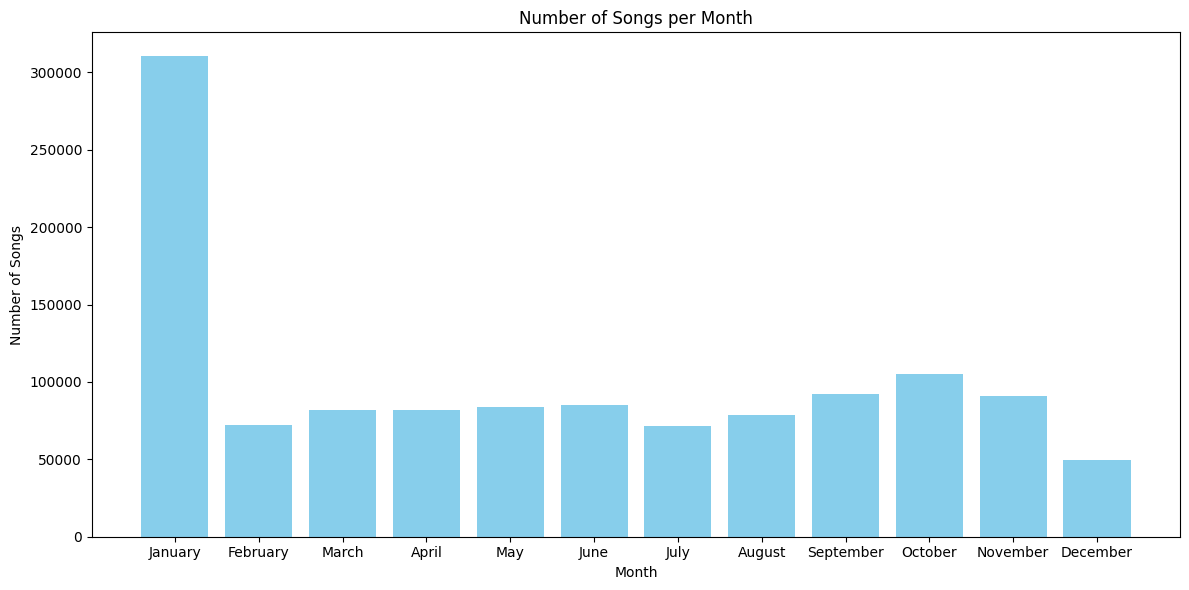

In [26]:
# Number of Songs per Month distribution
month_df = spotify_df.groupBy(F.month("release_date").alias("month")).count()
month_df = month_df.orderBy("month")
months = month_df.select("month").rdd.flatMap(lambda x: x).collect()
counts = month_df.select("count").rdd.flatMap(lambda x: x).collect()
month_names = [calendar.month_name[month] for month in months]

plt.figure(figsize=(12, 6))
plt.bar(month_names, counts, color='skyblue')
plt.xlabel("Month")
plt.ylabel("Number of Songs")
plt.title("Number of Songs per Month")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

The month that has the most released songs is January and the month that has the least released songs is December.

<!-- calculate correlation between data columns -->
### **Correlation of Data Columns**

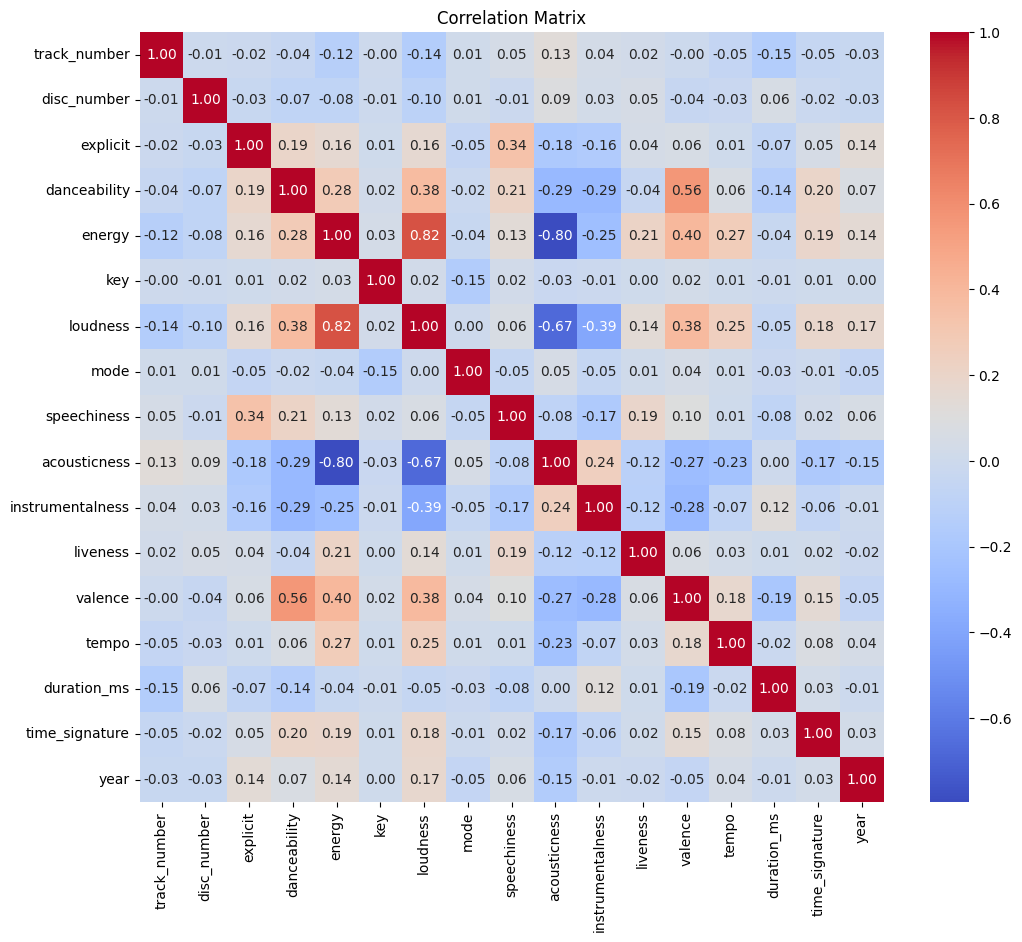

In [27]:
numerical_cols = ["track_number", "disc_number", "explicit", "danceability", "energy", "key", "loudness", "mode", "speechiness",
                  "acousticness", "instrumentalness", "liveness", "valence", "tempo", "duration_ms", "time_signature", "year"]


numerical_df = spotify_df.select([col(column) for column in numerical_cols])
assembler = VectorAssembler(inputCols=numerical_cols, outputCol="features")
vector_df = assembler.transform(numerical_df).select("features")

corr_matrix = Correlation.corr(vector_df, "features").head()[0]

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix.toArray(), annot=True, cmap='coolwarm', fmt=".2f", xticklabels=numerical_cols, yticklabels=numerical_cols)
plt.title('Correlation Matrix')
plt.show()


The correlation between the `loudness` and `energy` is 0.82 which shows a strong positive correlation between these two columns.

The correlation between the `loudness` and `acousticness` is -0.67 which shows a negative correlation between these two columns.

Also the correlation between the `energy` and `acousticness` is -0.80. These correlations are expected because the loudness and energy are directly proportional to each other and the acousticness is inversely proportional to the energy.

Also the `valence` column has a medium positive correlation with the `danceability` column which is 0.56.

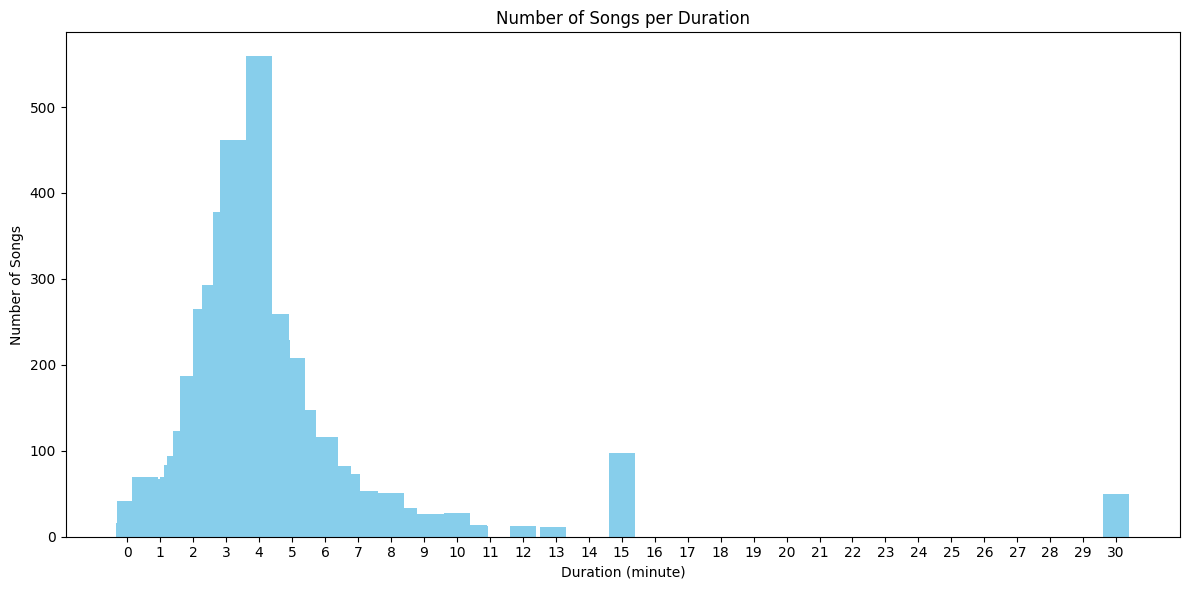

In [28]:
spotify_df = spotify_df.withColumn("duration_m", spotify_df["duration_ms"]/(1000 * 60))
duration_df = spotify_df.groupBy("duration_m").count()
duration_df_filtered = duration_df.filter(duration_df["count"] > 10)
durations = duration_df_filtered.select("duration_m").rdd.flatMap(lambda x: x).collect()
counts = duration_df_filtered.select("count").rdd.flatMap(lambda x: x).collect()

plt.figure(figsize=(12, 6))
plt.bar(durations, counts, color='skyblue')
plt.xlabel("Duration (minute)")
plt.ylabel("Number of Songs")
plt.title("Number of Songs per Duration")
min_duration = min(durations)
max_duration = max(durations)
duration_range = range(int(min_duration), int(max_duration) + 1)
duration_counts = {duration: 0 for duration in duration_range}
plt.xticks(np.arange(min(duration_counts.keys()), max(duration_counts.keys()) + 1, 1))
plt.tight_layout()
plt.show()

# calc the mean duration
mean_duration = spotify_df.select(avg("duration_m")).collect()[0][0]
display(HTML(f"<h3>Mean Duration: {mean_duration:.2f} minutes</h3>"))

At first we convert the duration from milliseconds to minutes. Then we can see that the average duration of the songs is 4.15. There are some recordss with 15 minutes and 30 minutes duration which are outliers. The may be podcasts or audiobooks. The distribution of the duration of the songs is similar to normal distribution.

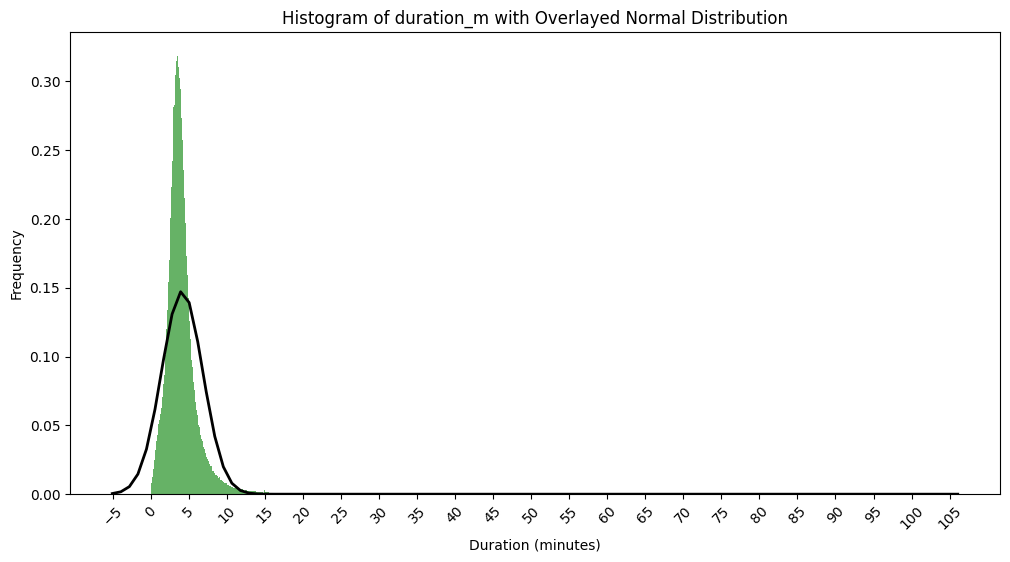

In [35]:
duration_s_values = spotify_df.select("duration_m").rdd.flatMap(lambda x: x).collect()

plt.figure(figsize=(12, 6))
plt.hist(duration_s_values, bins=2000, color='g', alpha=0.6, density=True)
mu, std = np.mean(duration_s_values), np.std(duration_s_values)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
plt.title("Histogram of duration_m with Overlayed Normal Distribution")
plt.xlabel("Duration (minutes)")
plt.ylabel("Frequency")
plt.xticks(np.arange(int(xmin), int(xmax) + 1, 5), rotation=45)

plt.show()

As we can see the normal distribution plot align with the actual distribution of the duration of the songs based on duration(minutes).

### Trends of Music Features

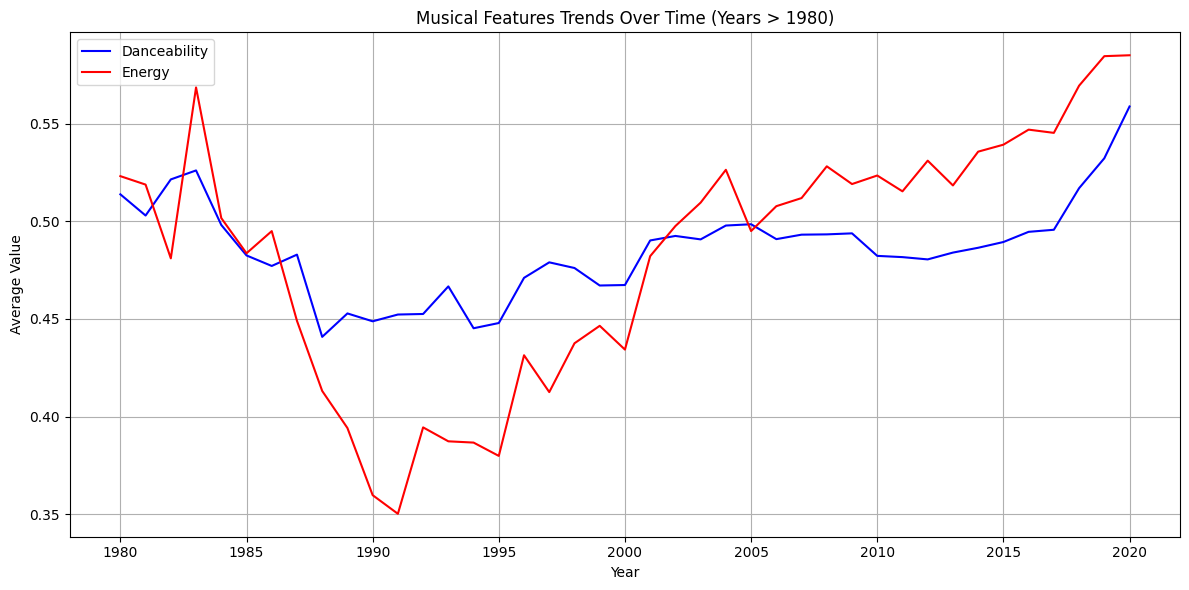

In [36]:
years_more_than_1980 = spotify_df.filter(spotify_df["year"] >= 1980)
yearly_avg_df = years_more_than_1980.groupBy("year").agg(avg("danceability").alias("avg_danceability"),
                                                avg("energy").alias("avg_energy")).orderBy("year")

plt.figure(figsize=(12, 6))

years = yearly_avg_df.select("year").rdd.flatMap(lambda x: x).collect()
avg_danceability = yearly_avg_df.select("avg_danceability").rdd.flatMap(lambda x: x).collect()
avg_energy = yearly_avg_df.select("avg_energy").rdd.flatMap(lambda x: x).collect()

plt.plot(years, avg_danceability, label="Danceability", color="blue")
plt.plot(years, avg_energy, label="Energy", color="red")

plt.xlabel("Year")
plt.ylabel("Average Value")
plt.title("Musical Features Trends Over Time (Years > 1980)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

The line graph shows the trends of two musical features, Danceability and Energy, over time.  
The danceability of music appears to have been increasing over time. It starts at around 0.53 in 1980 and reaches a high of around 0.58 in 2020. This suggests that music has become more dance-oriented over the past four decades.  
The energy of music also appears decreases over the years 1980 until 1992. After 1992, the energy of music starts to increase and reaches a high of around 0.58 in 2020. This suggests that music has become more energetic over the past decade.


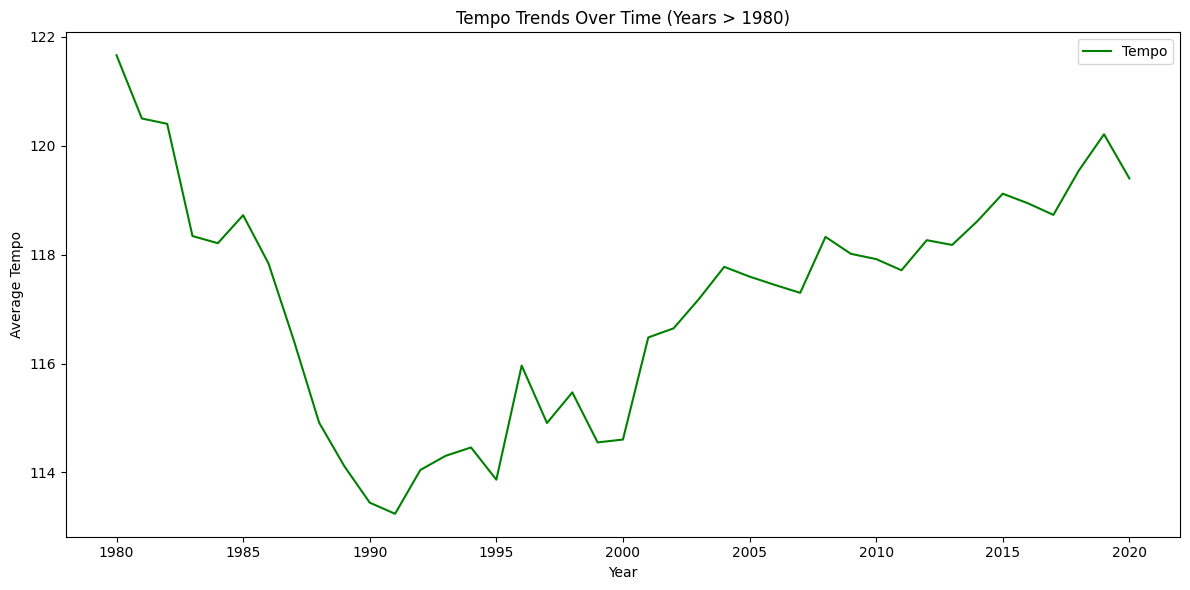

In [37]:
years_more_than_1980 = spotify_df.filter(spotify_df["year"] >= 1980)

yearly_avg_df = years_more_than_1980.groupBy("year").agg(avg("tempo").alias("avg_tempo")).orderBy("year")

plt.figure(figsize=(12, 6))

years = yearly_avg_df.select("year").rdd.flatMap(lambda x: x).collect()
avg_tempo = yearly_avg_df.select("avg_tempo").rdd.flatMap(lambda x: x).collect()

plt.plot(years, avg_tempo, label="Tempo", color="green")
plt.xlabel("Year")
plt.ylabel("Average Tempo")
plt.title("Tempo Trends Over Time (Years > 1980)")
plt.legend()
plt.tight_layout()
plt.show()


The average tempo dips slightly in the mid-1990s and then rises again in the early 2000s. This suggests that there may be variations in tempo based on musical trends that are not captured by this long-term view.

### Artists with the Most Songs

In order to find the artists with the most songs, we need to explode the `artists` and `artists_id` columns. At first we make a zip of these two features and explod them to add a new row for each (artis, artis_id) and add them to a new column named `artist_info`. 

In [38]:
combined_array = arrays_zip("artists", "artist_ids")
extended_spotify_df = spotify_df.withColumn("artist_info", explode(combined_array))
show_df(extended_spotify_df)

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------+-----------+--------+------------+------+---+------------------+----+-----------+------------+----------------+--------+-------+-------+-----------+--------------+----+------------+------------------+--------------------+
|                  id|                name|               album|            album_id|             artists|          artist_ids|track_number|disc_number|explicit|danceability|energy|key|          loudness|mode|speechiness|acousticness|instrumentalness|liveness|valence|  tempo|duration_ms|time_signature|year|release_date|        duration_m|         artist_info|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------+-----------+--------+------------+------+---+------------------+----+-----------+------------+----------------+--------+-------+-------+

In [55]:
artist_song_count = extended_spotify_df.groupBy("artist_info.artists", "artist_info.artist_ids") \
                                       .count() \
                                       .orderBy(desc("count"))

artist_song_count.show()

+--------------------+--------------------+-----+
|             artists|          artist_ids|count|
+--------------------+--------------------+-----+
|Johann Sebastian ...|5aIqB5nVVvmFsvSdE...| 9708|
|Ludwig van Beethoven|2wOqMjp9TyABvtHdO...| 5768|
|Wolfgang Amadeus ...|4NJhFmfw43RLBLjQv...| 3919|
|George Frideric H...|1QL7yTHrdahRMpvNt...| 3096|
|     Antonio Vivaldi|2QOIawHpSlOwXDvSq...| 2901|
|         Neeme Järvi|5UHZvYJA0aPcJSLYk...| 2625|
|  Franz Joseph Haydn|656RXuyw7CE0dtjdP...| 2245|
|     Various Artists|0LyfQWJT6nXafLPZq...| 2232|
|Pyotr Ilyich Tcha...|3MKCzCnpzw3TjUYs2...| 2159|
|     Johannes Brahms|5wTAi7QkpP6kp8a54...| 2145|
|    Sergei Prokofiev|4kHtgiRnpmFIV5Tm4...| 2142|
|Slovak Radio Symp...|428GNN7qZnTsMaK3S...| 2102|
| Dmitri Shostakovich|6s1pCNXcbdtQJlsnM...| 2100|
|     Frédéric Chopin|7y97mc3bZRFXzT2sz...| 2059|
|      Franz Schubert|2p0UyoPfYfI76PCSt...| 1888|
|         Traditional|1U5zgr455OGyIkLNX...| 1888|
|     Robert Schumann|2UqjDAXnDxejEyE0C...| 1732|


In this part we will plot the top 20 artists with the most songs. 

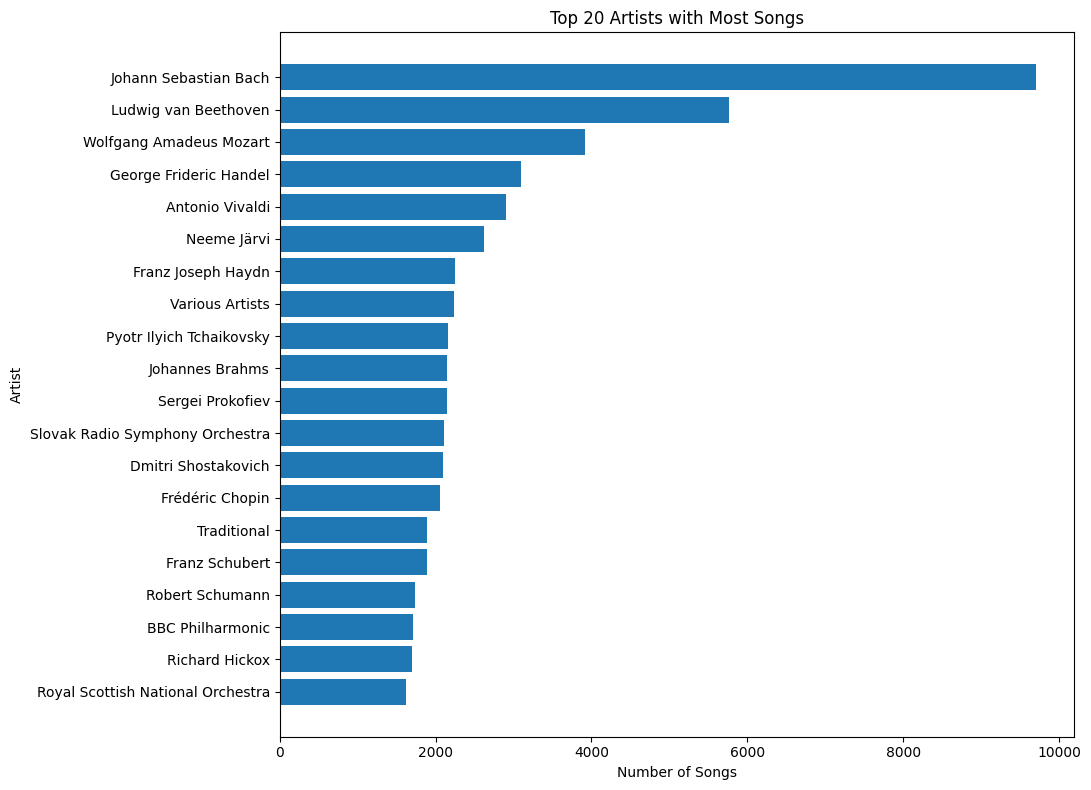

In [42]:
artist_song_count = extended_spotify_df.groupBy("artist_info.artists", "artist_info.artist_ids") \
                                       .count() \
                                       .orderBy(desc("count"))

top_20_artists = artist_song_count.limit(20).collect()

top_20_artists_names = [row["artists"] for row in top_20_artists]
top_20_artists_counts = [row["count"] for row in top_20_artists]

top_20_artists = list(zip(top_20_artists_names, top_20_artists_counts))

top_20_artists_sorted = sorted(top_20_artists, key=lambda x: x[1], reverse=False)

sorted_names, sorted_counts = zip(*top_20_artists_sorted)

plt.figure(figsize=(11, 8))
plt.barh(sorted_names, sorted_counts)
plt.xlabel("Number of Songs")
plt.ylabel("Artist")
plt.title("Top 20 Artists with Most Songs")

plt.tight_layout()
plt.show()

As we can see from the plot, the artist with the most songs is `Johann Sebastian Bach` 

In [47]:
# Top Artists with Most Songs in each Year
top_artists = extended_spotify_df.groupBy("year", "artist_info.artists", "artist_info.artist_ids") \
																.count() \
																.orderBy("year", desc("count"))

window = Window.partitionBy("year").orderBy(desc("count"))
top_artists = top_artists.withColumn("rank", F.rank().over(window))

top_artists = top_artists.filter(top_artists["rank"] <= 1)

top_artists.show()

+----+--------------------+--------------------+-----+----+
|year|             artists|          artist_ids|count|rank|
+----+--------------------+--------------------+-----+----+
|   0|             iCizzle|7arv4matK2uKJrdtP...|   10|   1|
|1900|   Rabih Abou-Khalil|7cM9Y2LNnnmmqivaE...|   14|   1|
|1908|Scotty And The Ri...|1P2BhUJ1N1bRIF52G...|    4|   1|
|1908|           A.C. Reed|1i31XKLddtEeOIr0n...|    4|   1|
|1908|           Lovie Lee|6cOz9TMiL8lfsFoWk...|    4|   1|
|1908|         Lacy Gibson|54sySc5ynnkqxkG2d...|    4|   1|
|1909|    Sexteto Nacional|27bcTAubEe7Vk3BBl...|    3|   1|
|1909|  Lecuona Cuban Boys|1caavwmrK3ucbb8fG...|    3|   1|
|1917|     Igor Stravinsky|7ie36YytMoKtPiL7t...|    3|   1|
|1920|Mamie Smith & Her...|4b5VF4fhFyyoWCf0d...|   17|   1|
|1923|Louis Armstrong &...|0t4VVR2T9Sb0z3NdD...|   13|   1|
|1924|     Bix Beiderbecke|3kfbYBrL3MCPAMUwK...|   36|   1|
|1925|        Ethel Waters|3INcDDCxVKMIQT6rf...|   17|   1|
|1926|         Fats Waller|0DYWCXTkNqGFZ

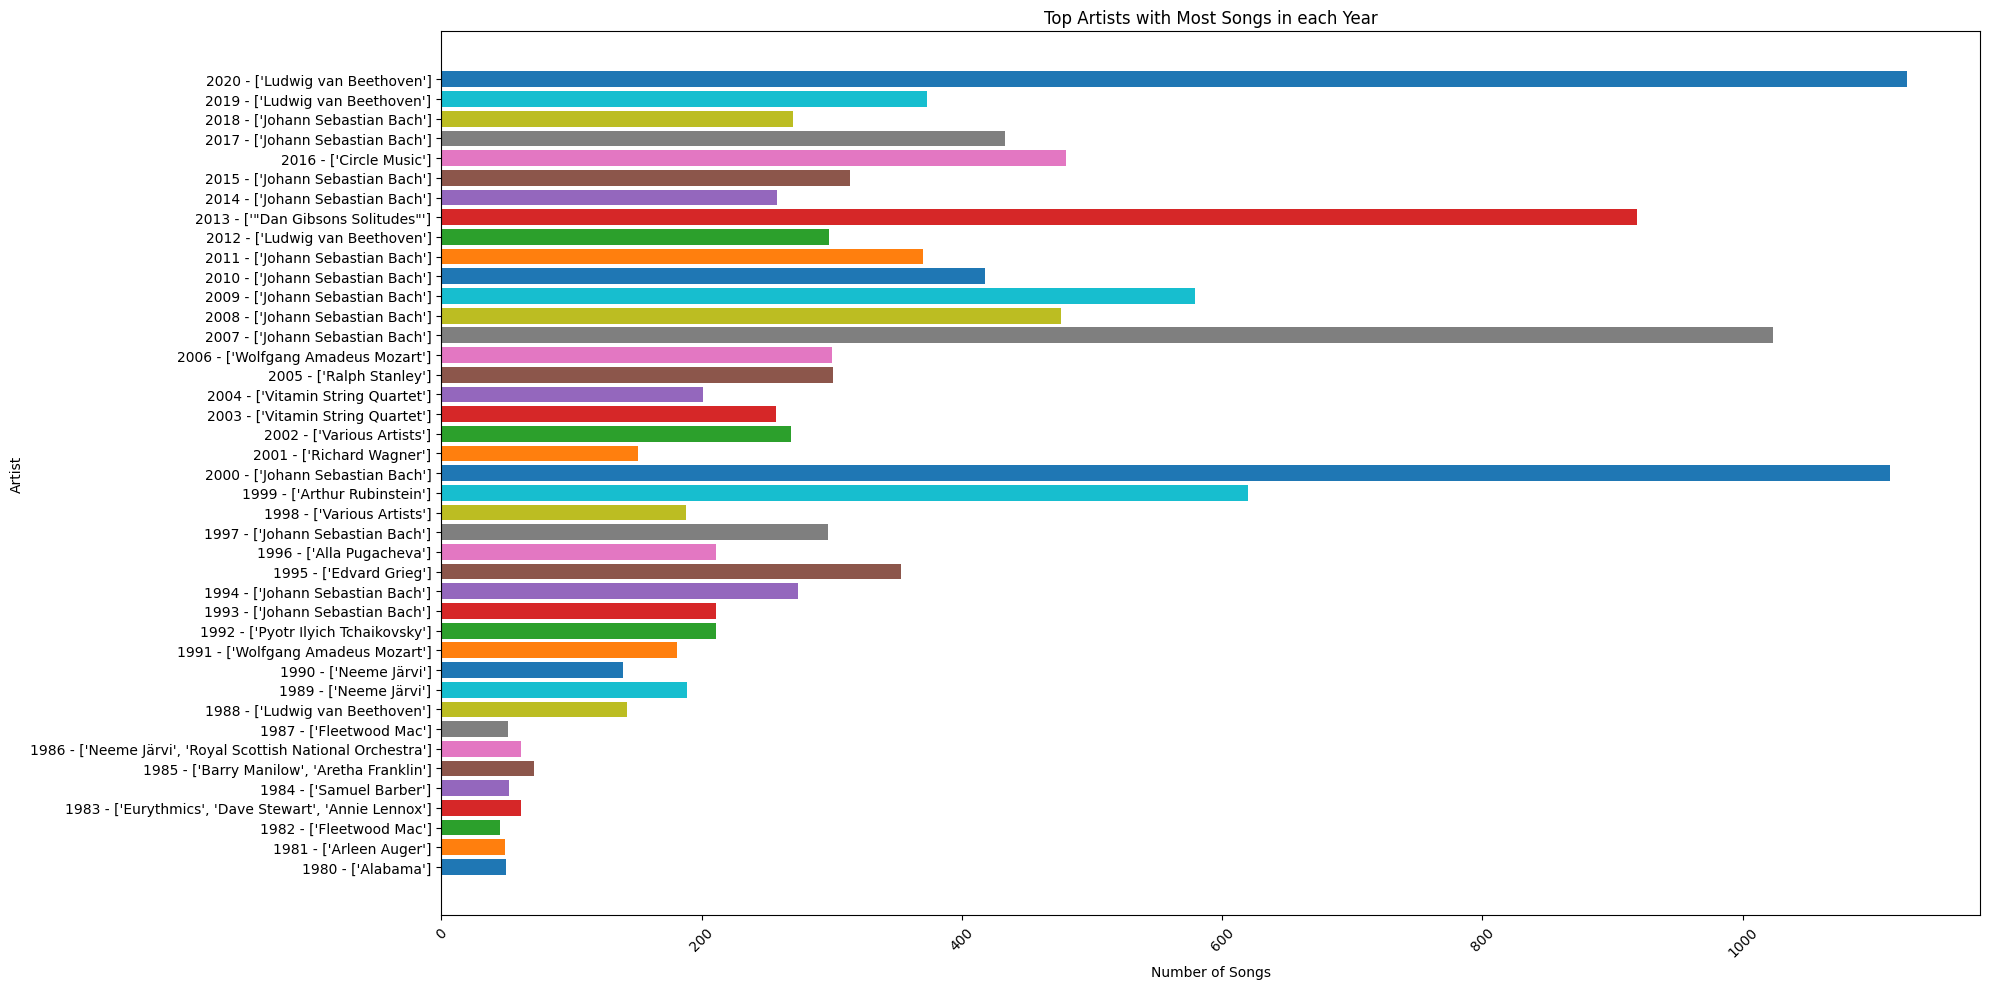

In [66]:
# plot Top Artists with Most Songs and their count in each Year
top_artists = extended_spotify_df.groupBy("year", "artist_info.artists", "artist_info.artist_ids") \
																.count() \
																.orderBy("year", desc("count"))
                                                                            
                                                                             
window = Window.partitionBy("year").orderBy(desc("count"))
top_artists = top_artists.withColumn("rank", F.rank().over(window))

top_artists = top_artists.filter(top_artists["rank"] <= 1)

plt.figure(figsize=(20, 10))

for year in range(1980, 2021):
	year_top_artists = top_artists.filter(top_artists["year"] == year).collect()
	artists = [row["artists"] for row in year_top_artists]
	counts = [row["count"] for row in year_top_artists]
	plt.barh(f'{year} - {artists}', counts, label= artists)


plt.xlabel("Number of Songs")
plt.ylabel("Artist")
plt.title("Top Artists with Most Songs in each Year")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

                                   

### Artist with the Most Albums

In [51]:
# Top Artists with Most Albums
top_album_artists = extended_spotify_df.groupBy("artist_info.artists", "artist_info.artist_ids", "album") \
																			 .count() \
																			 .orderBy(desc("count"))

top_album_artists.show()

+--------------------+--------------------+--------------------+-----+
|             artists|          artist_ids|               album|count|
+--------------------+--------------------+--------------------+-----+
|George Frideric H...|1QL7yTHrdahRMpvNt...|     Handel: Messiah|  218|
|           Carl Orff|4LXxsm5BF85PWnQ1d...|Orff: Carmina Burana|  177|
|Ludwig van Beethoven|2wOqMjp9TyABvtHdO...|Beethoven: The Co...|  150|
|    Benjamin Britten|7MJ1pB5d6Vjmzep2z...|Britten: Albert H...|  123|
|      Giuseppe Verdi|1JOQXgYdQV2yfrhew...|         Verdi: Aida|  100|
|Ludwig van Beethoven|2wOqMjp9TyABvtHdO...|Beethoven: Comple...|  100|
|         Chris Brown|7bXgB6jMjp9ATFy66...|Heartbreak On A F...|  100|
|      Laurent Martin|2uBb9urjWHXkYCihr...|Alkan: Esquisses,...|   98|
|Charles-Valentin ...|07OhqeLloDO7wu0yC...|Alkan: Esquisses,...|   98|
|        Hanns Eisler|3rpg4ZYZD022PbJxX...| Eisler: Vocal Music|   98|
| Dmitri Shostakovich|6s1pCNXcbdtQJlsnM...|Shostakovich: 24 ...|   96|
|Johan

## **Key Findings and Insights**

  * The Spotify database contains more non-explicit songs than explicit ones, and the number of explicit songs has increased over the years. By examining the percentage of explicit songs relative to all songs in each year, we observe a steady rise in the proportion of explicit content.

  * Over the years, the number of songs added to the Spotify database has consistently increased, with the highest number recorded in 2020.

  * January emerges as the month with the highest number of song releases, while December records the lowest. This trend offers insight into the preferred times of the year for artists to release their music.

  * Strong positive correlations exist between `loudness` and `energy`, while `loudness` demonstrates a negative correlation with `acousticness`, and `energy` with `acousticness`. Additionally, a moderate positive correlation is observed between `valence` and `danceability`.

  * The average duration of songs is approximately 4.15 minutes. Notably, some records feature significantly longer durations, such as 15 or 30 minutes, which may indicate the presence of podcasts or audiobooks. The distribution of song durations follows a pattern akin to a normal distribution.

  * Analysis reveals an increasing trend in the danceability of music over time, with a noticeable rise from around 0.53 in 1980 to approximately 0.58 in 2020. It seems like people prefer more danceable songs over time.

  * The most songs in the spotify database belongs to `Classical` genre. Among the top artists with most songs we can see `Johann Sebastian Bach` and `Ludwig van Beethoven` which are classical music composers. This prevalence can be attributed to the public domain status of their music, allowing for widespread covers and remixes without copyright constraints.


## **Questions**

`Question 1:  Read about how Spark and Hadoop work. What does the term ‘lazy evaluation’ mean
for them? Explain with a simple example.`  
Spark and Hadoop are both frameworks used for big data processing, but they have different architectures and approaches.  
- Hadoop: Hadoop is a distributed computing framework designed to handle large-scale data processing across clusters of commodity hardware. It operates on a master-slave architecture and consists of several key components:  
  &nbsp;&nbsp;&nbsp;&nbsp;Hadoop Distributed File System (HDFS): It stores data in a distributed manner across multiple machines, with replication for fault tolerance. Files in HDFS are divided into blocks, typically 128 MB or 256 MB in size, and distributed across the cluster.  
  &nbsp;&nbsp;&nbsp;&nbsp;MapReduce: MapReduce is a programming model and processing engine used for processing and generating large datasets in parallel across a Hadoop cluster. It divides processing into two phases: Map and Reduce.  
  &nbsp;&nbsp;&nbsp;&nbsp;Yet Another Resource Negotiator (YARN): YARN is the resource management and job scheduling component of Hadoop. It manages resources (CPU, memory) across the cluster and allocates them to running applications.  
- Spark: Spark is a distributed computing framework that provides an in-memory data processing engine, allowing for faster data processing compared to Hadoop MapReduce. It offers a variety of APIs including Scala, Java, Python, and SQL for data processing tasks. Spark operates on Resilient Distributed Datasets (RDDs), which are distributed collections of data that can be cached in memory across a cluster of machines.
- Lazy Evaluation: Lazy evaluation is a programming strategy where an expression is not evaluated until its value is actually needed. In other words, the computation is delayed until the result is required by another part of the program. This approach can lead to efficiency gains by avoiding unnecessary computations, especially in scenarios where the result might not be needed at all or might be needed only partially. In the context of Spark and Hadoop, lazy evaluation means that transformations on data (such as filtering, mapping, or aggregating) are not executed immediately. Instead, they are recorded as a series of transformations on the input data.
Actions, such as collecting data or saving it to disk, trigger the execution of these transformations.
- Example: Consider the following code snippet in Spark using the Python API (PySpark):
```python
# Create an RDD from a list
data = [1, 2, 3, 4, 5]
rdd = spark.sparkContext.parallelize(data)

# Apply transformations (lazy)
transformed_rdd = rdd.filter(lambda x: x % 2 == 0).map(lambda x: x * 2)

# Action: collect the result
result = transformed_rdd.collect()
```
In this example, filter and map are transformations applied to the RDD rdd. These transformations are lazily evaluated, meaning they are not executed immediately. When collect is called, it triggers the execution of the transformations, and the filtered and mapped data is collected and returned as the result.

`Question 2: Your main task’s dataset has about 1,200,000 rows, which makes it quite hard, and even sometimes impossible, to work with. Explain how parquet files try to solve this problem, compared to normal file formats like csv.`
Parquet files offer a highly optimized and scalable solution for storing and processing large datasets.
- Parquet files organize data by column rather than by row. Each column is stored separately, allowing for highly efficient compression and encoding techniques to be applied independently to each column. This columnar storage format reduces the amount of I/O required to read specific columns, leading to faster query performance.
- Parquet files support advanced compression algorithms, which can significantly reduce the storage footprint of the data. This compression reduces disk space usage and I/O operations, making it easier to work with large datasets.
- Parquet files store metadata about the data, such as data types and encoding, within the file itself. This metadata allows for efficient schema evolution and data pruning, enabling faster query execution by skipping irrelevant data.
- Parquet files are splittable, meaning that they can be divided into smaller chunks that can be processed in parallel. This feature allows for parallel processing of data across multiple nodes in a distributed computing environment, improving overall performance.

`Question 3: As you might have noticed, Spark doesn’t save checkpoints. How can we enforce it to do so? This can help us if we have multiple computation steps and we don’t want to wait a lot for the result.`  
In Spark, you can enforce checkpointing to save intermediate RDDs to disk by using the checkpoint() method. Before performing any operations that require checkpointing, we need to enable checkpointing in our SparkSession.
```python
spark.sparkContext.setCheckpointDir("hdfs://path/to/checkpoint_directory")
```
After enabling checkpointing, we can call the checkpoint() method on an RDD to trigger the checkpointing process.
```python
transformed_rdd.checkpoint()
```

`Question 4: Top companies stream their data on a regular routine, e.g. daily. How can we save data, so that we could filter it based on specific columns, e.g. date, faster than regular filtering?`
To save data in a way that allows for faster filtering based on specific columns, we can use partitioning. Storing the streaming data in a columnar format rather than a row-based format can improve query performance, especially when filtering based on specific columns like date. Also partitioning the data based on the column(s) we want to filter on can redduce the amount of data that needs to be scanned during filtering operations. For example, if we partition the data by date, we can quickly filter the data based on the date column without scanning the entire dataset.

`Question 5: Let's face off Pandas and PySpark in the data analysis arena! When does each library truly shine, and why? Consider factors like data size, processing complexity, and user experience.`
- Data Size: Pandas is well-suited for working with small to medium-sized datasets that can fit into memory on a single machine. On the other hand, PySpark is designed for processing large-scale datasets that are distributed across a cluster of machines, allowing for parallel processing and scalability.
- Processing Complexity: Pandas is ideal for interactive data analysis and exploration, as it provides a rich set of data manipulation and analysis tools. It is well-suited for complex data transformations, feature engineering, and statistical analysis. PySpark, on the other hand, is optimized for data processing tasks like ETL (Extract, Transform, Load), machine learning, and graph processing and provides rich set of APIs.
- User Experience: Pandas offers a user-friendly and intuitive interface for data analysis, It's syntax is easy to understand and use. PySpark, on the other hand, has a steeper learning curve due to its distributed nature and the need to understand concepts like RDDs, transformations, and actions. Also the syntax is less intuitive compared to Pandas.  

PySpark shines when it comes to scalability. This scalability makes PySpark ideal for big data analytics in production environments. In the realm of data manipulation and exploration, Pandas library shines as a versatile tool. The ability to handle complex data structures is crucial, especially when dealing with datasets that involve nested lists
